# Build Tokenizer

In this notebook, we will create our gpt2-based tokenizer object to work with our data.


In [1]:
import pandas as pd
from rich import print
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
sns.set_theme(context='notebook', style='dark')

In [3]:
model_ckpt = 'openai-community/gpt2'

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  # model_max_length=128
print(tokenizer)

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, 
padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': 
'<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
        50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, 
special=True),
}

In [5]:
data = load_dataset('csv', data_files='../data/wikipeda.csv')
print(data)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 5963366
    })
})

In [6]:
sample_text = data['train'][0]['text']
print(sample_text)

الماء مادة شفافة عديمة اللون والرائحة، وهو المكون الأساسي للجداول والبحيرات والبحار والمحيطات وكذلك للسوائل في جميع
الكائنات الحية، وهو أكثر المركبات الكيميائية انتشارا على سطح الأرض. يتألف جزيء الماء من ذرة أكسجين مركزية ترتبط بها
ذرتا هيدروجين على طرفيها برابطة تساهمية بحيث تكون صيغته الكيميائية H2O. عند الظروف القياسية من الضغط ودرجة الحرارة 
يكون الماء سائلا؛ أما الحالة الصلبة فتتشكل عند نقطة التجمد، وتدعى بالجليد؛ أما الحالة الغازية فتتشكل عند نقطة 
الغليان، وتسمى بخار الماء.

In [7]:
def get_data_iterator(data, batch_size: int = 1024):
    for i in range(0, len(data), batch_size):
        yield data[i: i + batch_size]['text']


data_generator = get_data_iterator(data['train'])

In [8]:
new_tokenizer = tokenizer.train_new_from_iterator(
    data_generator, vocab_size=8192)

In [9]:
print(new_tokenizer)

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=8192, model_max_length=1024, is_fast=True, 
padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': 
'<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
        0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, 
special=True),
}

In [10]:
tokenized_data = data.map(lambda x: new_tokenizer(x['text']), batched=True)
print(tokenized_data)

Parameter 'function'=<function <lambda> at 0x7fcf96694540> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/5963366 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1656 > 1024). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 5963366
    })
})

In [11]:
# print(tokenized_data[0]['input_ids'])

In [12]:
print(new_tokenizer.special_tokens_map)

{'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}

In [13]:
tokenized_data = tokenized_data.map(
    lambda x: {'num_tokens': [len(ids) for ids in x['input_ids']]}, batched=True)
print(tokenized_data)

Map:   0%|          | 0/5963366 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask', 'num_tokens'],
        num_rows: 5963366
    })
})

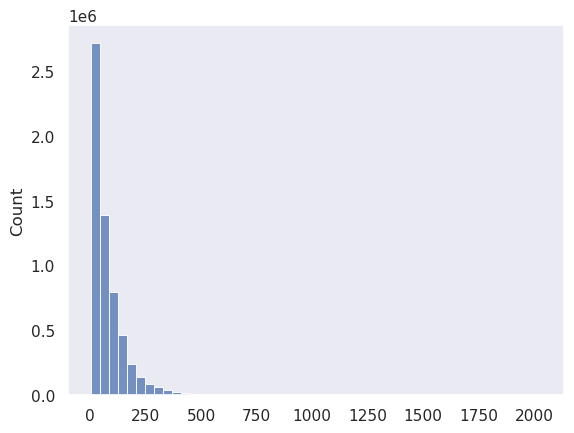

In [15]:
_ = sns.histplot(tokenized_data['train']['num_tokens'], bins=50)

In [16]:
max(tokenized_data['train']['num_tokens'])

2033

In [18]:
# model_max_length = (max(tokenized_data['train']['num_tokens']) // 512) * 512
# if model_max_length == 0:
#     model_max_length = 512

# print(model_max_length)

In [19]:
# new_tokenizer.model_max_length = model_max_length

In [20]:
print(new_tokenizer)

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=8192, model_max_length=1024, is_fast=True, 
padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': 
'<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
        0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, 
special=True),
}

In [21]:
new_tokenizer.save_pretrained('../models/nano-gpt-tokenizer')

('../models/nano-gpt-tokenizer/tokenizer_config.json',
 '../models/nano-gpt-tokenizer/special_tokens_map.json',
 '../models/nano-gpt-tokenizer/vocab.json',
 '../models/nano-gpt-tokenizer/merges.txt',
 '../models/nano-gpt-tokenizer/added_tokens.json',
 '../models/nano-gpt-tokenizer/tokenizer.json')